# Decision Tree and Random Forest


### Import Packages

In [1]:
import numpy as np
import pandas as pd
import math
import random
import csv
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['Arial']  # 或 'DejaVu Sans'
plt.rcParams['font.family'] = 'sans-serif'
import warnings
warnings.filterwarnings("ignore", message="findfont")
from scipy.stats import randint
from sklearn import tree
from sklearn.base import clone
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, StratifiedKFold, TimeSeriesSplit
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report

### Global attributes
Define the global attributes. You can also add your own global attributes here

In [2]:
part1_output_path = 'Lab2_Part1.csv' # Your model prediction in part I to submit to eeclass
part2_output_path = 'Lab2_Part2.csv' # Your model prediction in part II to submit to eeclass

part1_output =  [] # save your model prediction in part I
part2_output = [] # save your model prediction in part II

# **1. Part I (50%)**
In this part, you need to implement the Decision Tree.

**⚠️Please save the prediction result for the testing data in a CSV file and submit it to eeclass. This file will be used to evaluate your assignment⚠️**

### Step 1: Load the input data

The first step, load the input files.

You can take a look at the input features & the ground truth format:

In [3]:
# --- 1. 載入和準備資料 ---
print("步驟 1: 載入 '2330.csv'...")
try:
    df = pd.read_csv('2330.csv')
except FileNotFoundError:
    print("錯誤：找不到 '2330.csv' 檔案。")
    # 結束執行
    exit()
except Exception as e:
    print(f"載入 CSV 時發生錯誤：{e}")
    # 結束執行
    exit()
# 轉換日期並設為索引
try:
    df['Date'] = pd.to_datetime(df['Date'])
    df = df.set_index('Date')
    df = df.sort_index()
except KeyError:
    print("錯誤：CSV 中找不到 'Date' 欄位。")
    sys.exit() # 結束執行
except Exception as e:
    print(f"轉換日期時發生錯誤：{e}")
    sys.exit() # 結束執行

# 【修正】增加檢查點
print(f"資料載入並設定日期索引完畢。索引型態：{type(df.index)}")
if not isinstance(df.index, pd.DatetimeIndex):
    print("警告：索引未成功設定為 DatetimeIndex，後續日期顯示可能不正確。")
    # 即使這樣，我們仍然嘗試繼續執行，因為模型訓練不依賴於索引

步驟 1: 載入 '2330.csv'...
資料載入並設定日期索引完畢。索引型態：<class 'pandas.core.indexes.datetimes.DatetimeIndex'>


In [11]:
# --- 2. 特徵工程：定義目標變數 (Y) ---
print("步驟 2: 建立目標變數 'Target' (隔天漲=1, 跌=0)...")
# 目標：預測隔天股價是漲 (1) 還是跌/平 (0)
# 我們用 'Close' 的變化來定義
df['Target'] = (df['Close'].shift(-2) > df['Close']).astype(int)

步驟 2: 建立目標變數 'Target' (隔天漲=1, 跌=0)...


In [12]:
# ----------------------------------------------------------------------
# --- 【步驟 2】生成所有缺失的相對/外部指標特徵 ---
# ----------------------------------------------------------------------

print("步驟 2: 生成所有相對/外部指標特徵...")

# 1. 股價 vs. 均線 (二元趨勢判斷)
# 1 if Close > MA, 0 otherwise.
# 假設 MA5, MA10, EMA5, EMA10 欄位已存在於原始 df 中
df['P_vs_MA5'] = (df['Close'] > df['MA5']).astype(int)
df['P_vs_MA10'] = (df['Close'] > df['MA10']).astype(int)
df['P_vs_EMA5'] = (df['Close'] > df['EMA5']).astype(int)
df['P_vs_EMA10'] = (df['Close'] > df['EMA10']).astype(int)

# 2. 標準化波動率與日動能 (不依賴絕對價格)
df['Daily_Range_Ratio'] = (df['High'] - df['Low']) / df['Close']
df['Open_Close_Percent'] = (df['Close'] - df['Open']) / df['Open'] * 100

# 3. 外部市場指標 (轉換為日百分比變化)
# *** 這裡使用了 fill_method=None 來避免未來版本警告 ***
df['DJI_PCT_CHG'] = df['DJI'].pct_change(fill_method=None) * 100
df['NASDAQ_PCT_CHG'] = df['NASDAQ'].pct_change(fill_method=None) * 100
df['SOX_PCT_CHG'] = df['SOX'].pct_change(fill_method=None) * 100
df['SPX_PCT_CHG'] = df['SPX'].pct_change(fill_method=None) * 100
df['ADR_PCT_CHG'] = df['ADR'].pct_change(fill_method=None) * 100
# df['TW_PCT_CHG'] = df['twclose'].pct_change(fill_method=None) * 100 

print("所有相對/外部指標特徵生成完畢。")
# ----------------------------------------------------------------------

步驟 2: 生成所有相對/外部指標特徵...
所有相對/外部指標特徵生成完畢。


In [13]:
# --- 3. 定義特徵 (X) ---
print("步驟 3: 定義特徵 (X)...")
# 這個列表包含原始有效的指標，以及所有新的相對/標準化特徵
features = [
    # 原始成交量/筆數 (非價格數據，保留)
    'Capacity', 'Turnover', 'Transaction', 
    'MA5_Capacity', 

    # 原始價格相對指標 (保留)
    'Change', 'High-Low', 'Open-Close',
    
    # 原始震盪指標 (保留)
    'BR5', 'BR10', 'K', 'D',
    'MACD', 'MACD_signal', 'MACD_hist',
    'RSI14', 'RSI', 'STD20', 'ADX',
    
    # 【新增特徵】: 股價相對均線 (二元)
    'P_vs_MA5', 'P_vs_MA10', 'P_vs_EMA5', 'P_vs_EMA10', 

    # 【新增特徵】: 標準化波動與動能 (比例)
    'Daily_Range_Ratio', 
    'Open_Close_Percent',
    
    # 【新增特徵】: 外部市場變動 (百分比)
    'DJI_PCT_CHG', 'NASDAQ_PCT_CHG', 'SOX_PCT_CHG', 'SPX_PCT_CHG', 'ADR_PCT_CHG', 'TW_PCT_CHG',
    # 'Net_Dealer', 
    # 'Net_Dealer_Hedging', 
    # 'Net_Dealer_Self', 
    # 'Net_Foreign_Dealer_Self', 
    # 'Net_Foreign_Investor', 
    # 'Net_Investment_Trust'
]

# 確保所有特徵都存在
available_features = [col for col in features if col in df.columns]
if len(available_features) < len(features):
    print(f"警告：部分特徵不存在。將使用以下 {len(available_features)} 個可用特徵：{available_features}")

if not available_features:
    print("錯誤：選擇的特徵均不存在於 CSV 中。")
    # 結束執行
    exit()
    
features = available_features # Use only available features

步驟 3: 定義特徵 (X)...
警告：部分特徵不存在。將使用以下 29 個可用特徵：['Capacity', 'Turnover', 'Transaction', 'MA5_Capacity', 'Change', 'High-Low', 'Open-Close', 'BR5', 'BR10', 'K', 'D', 'MACD', 'MACD_signal', 'MACD_hist', 'RSI14', 'RSI', 'STD20', 'ADX', 'P_vs_MA5', 'P_vs_MA10', 'P_vs_EMA5', 'P_vs_EMA10', 'Daily_Range_Ratio', 'Open_Close_Percent', 'DJI_PCT_CHG', 'NASDAQ_PCT_CHG', 'SOX_PCT_CHG', 'SPX_PCT_CHG', 'ADR_PCT_CHG']


In [14]:
# --- 4. 清理資料 ---
print("步驟 4: 清理資料 (移除 NaN)...")

df.replace([np.inf, -np.inf], np.nan, inplace=True)

# 移除 'Target' 為 NaN 的最後一筆資料
# 移除 'features' 中任何為 NaN 的資料 (例如早期的 MA, RSI 等)
df_clean = df[features + ['Target']].dropna()

if df_clean.empty:
    print("錯誤：清理 NaN 資料後，沒有剩餘資料可供訓練。")
    # 結束執行
    exit()

X = df_clean[features]
y = df_clean['Target']

print(f"原始資料筆數：{len(df)}, 清理 (dropna) 後筆數：{len(df_clean)}")
print(f"X (features) shape: {X.shape}, y (target) shape: {y.shape}")

步驟 4: 清理資料 (移除 NaN)...
原始資料筆數：3887, 清理 (dropna) 後筆數：3854
X (features) shape: (3854, 29), y (target) shape: (3854,)


In [15]:
# --- 5. 資料分割 (時間序列) ---
print(f"步驟 5: 執行『時間序列』資料分割...")
# **這一步與 Lab2 非常不同！**
# 股票資料是時間序列，不能隨機
# 我們必須用 '過去' 訓練，'未來' 測試

# 檢查是否有足夠的資料進行分割
if len(X) < 10: 
    print("錯誤：資料筆數太少，無法進行訓練/測試分割。")
    # 結束執行
    exit()
    
split_ratio = 0.6311
split_point = int(len(X) * split_ratio)

print(f'訓練集：{split_ratio*100}%')

if split_point == 0 or split_point == len(X):
    print("錯誤：無法以 80/20 比例分割資料，資料太少。")
    # 結束執行
    exit()

X_train = X.iloc[:split_point]
y_train = y.iloc[:split_point]
X_test = X.iloc[split_point:]
y_test = y.iloc[split_point:]

print(f"訓練集筆數：{len(X_train)} (從 {X_train.index.min().date()} 到 {X_train.index.max().date()})")
print(f"測試集筆數：{len(X_test)} (從 {X_test.index.min().date()} 到 {X_test.index.max().date()})")

步驟 5: 執行『時間序列』資料分割...
訓練集：63.11%
訓練集筆數：2432 (從 2010-02-26 到 2019-12-31)
測試集筆數：1422 (從 2020-01-02 到 2025-11-07)


In [16]:
# --- 6. 建立 Pipeline (仿照 Lab2) ---
print("步驟 6: 建立 Pipeline (SimpleImputer + DecisionTreeClassifier)...")
# Lab2 提到要處理缺失值，我們使用 SimpleImputer
# Lab2 提到決策樹不需要標準化 (StandardScaler)，所以我們不安插

# 建立一個只做 '填補缺失值' 的預處理器
# 雖然我們已經 dropna()，但這是仿照 Lab2 流程，以防萬一
numeric_transformer = SimpleImputer(strategy='mean')

# 建立 Pipleline： 1. 預處理 -> 2. 分類器
pipeline = Pipeline(steps=[
    ('preprocessor', numeric_transformer),
    # ('classifier', DecisionTreeClassifier(random_state=42)) # <-- 舊的
    ('classifier', RandomForestClassifier(random_state=42)) # <-- 換成這個
])

步驟 6: 建立 Pipeline (SimpleImputer + DecisionTreeClassifier)...


In [17]:
# --- 7. 訓練基本模型 ---
print("步驟 7: 訓練基本模型...")
try:
    pipeline.fit(X_train, y_train)
except Exception as e:
    print(f"訓練 pipeline 時發生錯誤：{e}")
    # 結束執行
    exit()

步驟 7: 訓練基本模型...


In [18]:
# --- 8. 評估基本模型 ---
print("\n--- 基本決策樹模型 (未調參) 評估 ---")
y_pred = pipeline.predict(X_test)
print(f"測試集 Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"測試集 F1-Score (Weighted): {f1_score(y_test, y_pred, average='weighted'):.4f}")
print("分類報告 (0=跌/平, 1=漲):")
print(classification_report(y_test, y_pred, digits=4))


--- 基本決策樹模型 (未調參) 評估 ---
測試集 Accuracy: 0.5809
測試集 F1-Score (Weighted): 0.5801
分類報告 (0=跌/平, 1=漲):
              precision    recall  f1-score   support

           0     0.5718    0.6252    0.5973       707
           1     0.5917    0.5371    0.5630       715

    accuracy                         0.5809      1422
   macro avg     0.5817    0.5811    0.5802      1422
weighted avg     0.5818    0.5809    0.5801      1422



In [19]:
# --- 9. 超參數調校 (GridSearchCV) ---
print("\n步驟 9: 開始執行 GridSearchCV (使用『TimeSeriesSplit』)...")
# **這一步也與 Lab2 非常不同！**
# Lab2 使用 StratifiedKFold，但這會打亂時間順序
# 對於時間序列，我們必須使用 TimeSeriesSplit

# param_grid = {
#     'classifier__max_depth': [3, 5, 7, 10, 15, 20, 25],
#     'classifier__min_samples_leaf': [10, 20, 30, 40, 50],
#     'classifier__criterion': ['gini', 'entropy']
# }

# RF
param_grid = {
    'classifier__n_estimators': [50, 100], # 樹的數量
    'classifier__max_depth': [5, 10],      # 每棵樹的最大深度
    'classifier__min_samples_leaf': [20, 50] # 葉節點最小樣本數
}

# 2. 【關鍵修改】建立 '參數分佈' (param_dist) 而非 '網格' (param_grid)
param_dist = {
    'classifier__n_estimators': randint(100, 250), # <-- 隨機從 50~199 中挑整數
    'classifier__max_depth': randint(5, 20),      # <-- 隨機從 5~19 中挑整數
    'classifier__min_samples_leaf': randint(10, 50) # <-- 隨機從 10~49 中挑整數
}

# 使用 TimeSeriesSplit 進行交叉驗證
tscv = TimeSeriesSplit(n_splits=5)

# RF
# grid_search = GridSearchCV(
#     pipeline,
#     param_grid,
#     cv=tscv,
#     scoring='f1_weighted', # 使用 'f1_weighted' 應對可能的不平衡
#     n_jobs=-1,
#     verbose=1
# )

# 3. 【關鍵修改】使用 RandomizedSearchCV
random_search = RandomizedSearchCV(
    pipeline, 
    param_distributions=param_dist,  # <-- 使用 param_distributions
    n_iter=30,                       # <-- 【關鍵】指定只嘗試 30 種隨機組合
    cv=tscv, 
    scoring='f1_weighted', 
    n_jobs=-1, 
    verbose=1,
    random_state=42 # 確保隨機結果可重現
)

try:
    random_search.fit(X_train, y_train) # 只在訓練集上調參
    
    # print("\nGridSearchCV 完成。")
    # print(f"最佳參數: {grid_search.best_params_}")
    print(f"最佳參數: {random_search.best_params_}")

    # --- 10. 評估最佳模型 ---
    # best_model = grid_search.best_estimator_
    best_model = random_search.best_estimator_
    y_pred_best = best_model.predict(X_test)

    print("\n--- 最佳決策樹模型 (GridSearchCV 調參後) 評估 ---")
    print(f"測試集 Accuracy: {accuracy_score(y_test, y_pred_best):.4f}")
    print(f"測試集 F1-Score (Weighted): {f1_score(y_test, y_pred_best, average='weighted'):.4f}")
    print("分類報告 (0=跌/平, 1=漲):")
    print(classification_report(y_test, y_pred_best, digits=4))

    # --- 11. (額外) 顯示特徵重要性 ---
    print("\n--- 最佳模型特徵重要性 (Top 10) ---")
    # 從 pipeline 中提取 'classifier'
    final_tree = best_model.named_steps['classifier']
    
    # 獲取重要性
    importances = final_tree.feature_importances_
    
    feature_importance_df = pd.DataFrame({
        'Feature': features,
        'Importance': importances
    }).sort_values(by='Importance', ascending=False)

    print(feature_importance_df.head(10).to_string())

except Exception as e:
    print(f"GridSearchCV 執行或評估時發生錯誤：{e}")
    # 即使 GridSearchCV 失敗，基本模型的結果也已經印出


步驟 9: 開始執行 GridSearchCV (使用『TimeSeriesSplit』)...
Fitting 5 folds for each of 30 candidates, totalling 150 fits
最佳參數: {'classifier__max_depth': 8, 'classifier__min_samples_leaf': 49, 'classifier__n_estimators': 231}

--- 最佳決策樹模型 (GridSearchCV 調參後) 評估 ---
測試集 Accuracy: 0.6217
測試集 F1-Score (Weighted): 0.6217
分類報告 (0=跌/平, 1=漲):
              precision    recall  f1-score   support

           0     0.6199    0.6181    0.6190       707
           1     0.6234    0.6252    0.6243       715

    accuracy                         0.6217      1422
   macro avg     0.6216    0.6216    0.6216      1422
weighted avg     0.6217    0.6217    0.6217      1422


--- 最佳模型特徵重要性 (Top 10) ---
               Feature  Importance
26         SOX_PCT_CHG    0.131239
28         ADR_PCT_CHG    0.117380
25      NASDAQ_PCT_CHG    0.112794
27         SPX_PCT_CHG    0.105113
24         DJI_PCT_CHG    0.070385
7                  BR5    0.043395
23  Open_Close_Percent    0.041733
8                 BR10    0.039605
16 


Step 13: Plotting Prediction Accuracy Over Time (prediction_accuracy_over_time.png)...
Prediction accuracy plot saved as 'prediction_accuracy_over_time.png'.


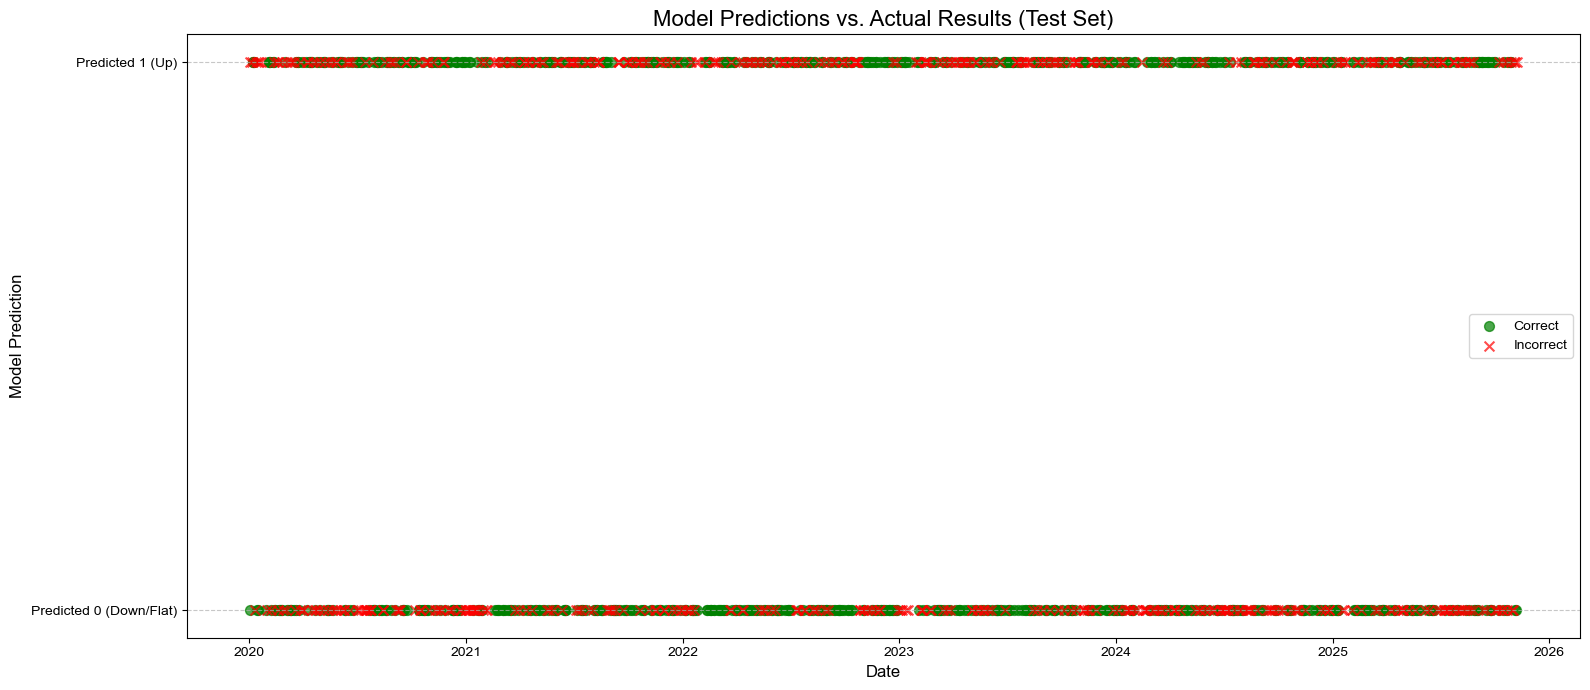

In [20]:
print("\nStep 13: Plotting Prediction Accuracy Over Time (prediction_accuracy_over_time.png)...")

if y_pred_best is None:
    print("Error: y_pred_best is missing, cannot plot accuracy.")
    sys.exit()

try:
    plot_df = pd.DataFrame(index=X_test.index)
    plot_df['Actual'] = y_test
    plot_df['Predicted'] = y_pred_best
    plot_df['is_correct'] = (plot_df['Actual'] == plot_df['Predicted'])
    
    correct_preds = plot_df[plot_df['is_correct'] == True]
    incorrect_preds = plot_df[plot_df['is_correct'] == False]
    
    plt.figure(figsize=(16, 7))
    
    # 畫出「猜對」的點
    plt.scatter(
        correct_preds.index, 
        correct_preds['Predicted'], 
        color='green', 
        label='Correct', # 英文
        alpha=0.7, 
        s=50,
        marker='o'
    )
    
    # 畫出「猜錯」的點
    plt.scatter(
        incorrect_preds.index, 
        incorrect_preds['Predicted'], 
        color='red', 
        label='Incorrect', # 英文
        alpha=0.7, 
        s=50, 
        marker='x'
    )
    
    # 【英文版】設定圖表樣式
    plt.yticks([0, 1], ['Predicted 0 (Down/Flat)', 'Predicted 1 (Up)'])
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Model Prediction', fontsize=12)
    plt.title('Model Predictions vs. Actual Results (Test Set)', fontsize=16)
    plt.legend(loc='best')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    
    output_filename = 'prediction_accuracy_over_time.png'
    plt.savefig(output_filename, dpi=150)
    
    print(f"Prediction accuracy plot saved as '{output_filename}'.")

except Exception as e:
    print(f"Error plotting accuracy over time: {e}")

In [22]:
# ----------------------------------------------------------------------
#  隨機森林模型 - 【機率閾值 (Probability Threshold) 分析】
#  (執行前請確保 X_test, y_test, best_model 已經定義)
# ----------------------------------------------------------------------

# 取得預測 (0.5 閾值)
y_pred_best = best_model.predict(X_test)
# 【新】取得機率
y_pred_proba = best_model.predict_proba(X_test)

print("\n--- Baseline Model Evaluation (5-Day Target, 0.5 Threshold) ---")
print(f"Overall Test Set Accuracy: {accuracy_score(y_test, y_pred_best):.4f}")
print("Overall Classification Report (0=Down/Flat, 1=Up):")
print(classification_report(y_test, y_pred_best, digits=4))

# --- 【新】機率分析 ---
print("\n--- High Confidence Strategy Analysis ---")

# 建立一個包含機率和實際結果的 DataFrame
prob_df = pd.DataFrame(index=X_test.index)
prob_df['Actual'] = y_test
# prob_df['Prob_0 (Down)'] = y_pred_proba[:, 0]
prob_df['Prob_1 (Up)'] = y_pred_proba[:, 1]
prob_df['Predicted (0.5 Thr)'] = y_pred_best

# 📊 設定信心門檻 (您可以調整這個值來觀察效果)
CONF_THRESHOLD = 0.7

# 找出「高信心」的預測
# 條件：(猜 1 機率 > 0.6) OR (猜 0 機率 > 0.6, 亦即 猜 1 機率 < 0.4)
high_conf_subset = prob_df[
    (prob_df['Prob_1 (Up)'] > CONF_THRESHOLD) | 
    (prob_df['Prob_1 (Up)'] < (1 - CONF_THRESHOLD))
]

if high_conf_subset.empty:
    print(f"WARNING: No predictions found with > {CONF_THRESHOLD*100}% confidence. Cannot evaluate strategy.")
else:
    # 計算「高信心」預測的準確率
    # 在高信心子集中，仍使用 0.5 閾值下的預測結果進行評估
    high_conf_accuracy = accuracy_score(
        high_conf_subset['Actual'], 
        high_conf_subset['Predicted (0.5 Thr)']
    )
    
    print(f"Total test days: {len(prob_df)}")
    print(f"High Confidence (> {CONF_THRESHOLD*100}%) days: {len(high_conf_subset)}")
    print(f"Percentage of days with High Confidence: {len(high_conf_subset)/len(prob_df) * 100:.2f}%")
    print("\n" + "="*30)
    print(f"Overall Accuracy (All days): {accuracy_score(y_test, y_pred_best):.4f}")
    print(f"High Confidence Accuracy: {high_conf_accuracy:.4f}")
    print("="*30)


--- Baseline Model Evaluation (5-Day Target, 0.5 Threshold) ---
Overall Test Set Accuracy: 0.6217
Overall Classification Report (0=Down/Flat, 1=Up):
              precision    recall  f1-score   support

           0     0.6199    0.6181    0.6190       707
           1     0.6234    0.6252    0.6243       715

    accuracy                         0.6217      1422
   macro avg     0.6216    0.6216    0.6216      1422
weighted avg     0.6217    0.6217    0.6217      1422


--- High Confidence Strategy Analysis ---
Total test days: 1422
High Confidence (> 70.0%) days: 119
Percentage of days with High Confidence: 8.37%

Overall Accuracy (All days): 0.6217
High Confidence Accuracy: 0.7731



Step 14: Plotting Prediction Probability Histogram (probability_histogram.png)...
Probability histogram saved as 'probability_histogram.png'.


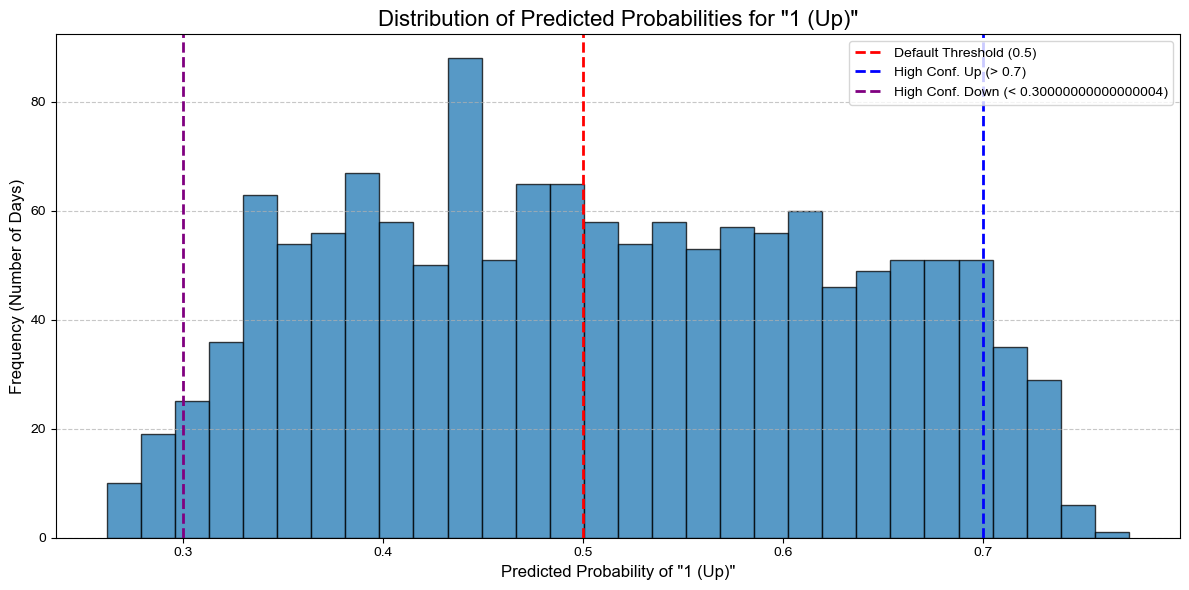

In [23]:
# ----------------------------------------------------------------------
# --- 【新】繪製機率分佈直方圖 ---
# ----------------------------------------------------------------------
print("\nStep 14: Plotting Prediction Probability Histogram (probability_histogram.png)...")
if y_pred_proba is None: 
    print("Error: y_pred_proba is missing, cannot plot histogram."); 
    # 由於此區塊需要 y_pred_proba，若缺失則退出
    sys.exit() 

try:
    # 我們只看「猜 1 (Up)」的機率
    prob_1_up = y_pred_proba[:, 1]
    
    plt.figure(figsize=(12, 6))
    
    # 繪製直方圖 (bins=30 將 0.0 到 1.0 之間切成 30 個長條)
    plt.hist(prob_1_up, bins=30, alpha=0.75, edgecolor='black')
    
    # 畫出輔助線
    # 預設門檻 (0.5)
    plt.axvline(0.5, color='red', linestyle='--', linewidth=2, label='Default Threshold (0.5)') 
    # 信心門檻 (猜漲)
    plt.axvline(CONF_THRESHOLD, color='blue', linestyle='--', linewidth=2, label=f'High Conf. Up (> {CONF_THRESHOLD})')
    # 信心門檻 (猜跌，機率低於 1-CONF_THRESHOLD)
    plt.axvline(1 - CONF_THRESHOLD, color='purple', linestyle='--', linewidth=2, label=f'High Conf. Down (< {1 - CONF_THRESHOLD})')
    
    plt.title('Distribution of Predicted Probabilities for "1 (Up)"', fontsize=16)
    plt.xlabel('Predicted Probability of "1 (Up)"', fontsize=12)
    plt.ylabel('Frequency (Number of Days)', fontsize=12)
    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    
    output_filename = 'probability_histogram.png'
    plt.savefig(output_filename, dpi=150)
    
    print(f"Probability histogram saved as '{output_filename}'.")

except Exception as e:
    print(f"Error plotting probability histogram: {e}")

In [56]:
import pandas as pd

# 確保 best_model 已經訓練好
# 取得預測機率 (predict_proba 會回傳 [跌的機率, 漲的機率])
# 我們只需要取出第二個欄位 (Index 1)，即「漲」的機率
y_pred_proba = best_model.predict_proba(X_test)[:, 1]

# 建立 DataFrame
result_df = pd.DataFrame({
    'Date': X_test.index,        # 日期
    'Prediction': y_pred_best,   # 原始預測 (0或1)
    'Probability': y_pred_proba  # 信心分數 (0.0 ~ 1.0)
})

# 儲存為新的 CSV
output_filename = 'TSMC_Prediction_Proba.csv'
result_df.to_csv(output_filename, index=False)

print(f"檔案已生成：{output_filename}")
print("前 5 筆資料 (含信心值)：")
print(result_df.head())

檔案已生成：TSMC_Prediction_Proba.csv
前 5 筆資料 (含信心值)：
        Date  Prediction  Probability
0 2020-01-02           1     0.514464
1 2020-01-03           1     0.586153
2 2020-01-06           1     0.562954
3 2020-01-07           1     0.540610
4 2020-01-08           1     0.530321
